In [25]:
# In this notebook, instead of predicting the voting level, we predict the FDP
# and then we do a grid search on the FDP function (entries are v and Phi)
# The dataset here are pairings of v, Phi with subsequent FDPs

In [26]:
import os
import torch
from numpy import dtype
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

data_dir = '/home/avp/TRex/data'

# A. Generate Data

In [27]:
#!Rscript generate_data_pred_FDR_all_v.R --N_data=10000

# B. Train Model

In [28]:
class PhiThreshDataset(Dataset):
    def __init__(self, data_dir):
        self.phi_dir = os.path.join(data_dir, 'Phi_mat')
        self.beta_dir = os.path.join(data_dir, 'beta')
        self.v_dir = os.path.join(data_dir, 'v')
        self.FDP_dir = os.path.join(data_dir, 'FDR')
        
        self.phi_files = [f for f in os.listdir(self.phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
        self.beta_files = [f for f in os.listdir(self.beta_dir) if f.startswith('beta_') and f.endswith('.txt')]
        self.v_files = [f for f in os.listdir(self.v_dir) if f.startswith('v_') and f.endswith('.txt')]
        self.FDP_files = [f for f in os.listdir(self.FDP_dir) if f.startswith('FDR_') and f.endswith('.txt')]

    def __len__(self):
        return len(self.phi_files)

    def __getitem__(self, idx):
        phi_file = os.path.join(self.phi_dir, self.phi_files[idx])
        phi = np.loadtxt(phi_file)

        beta_file = os.path.join(self.beta_dir, self.beta_files[idx])
        beta = np.loadtxt(beta_file)
        
        v_file = os.path.join(self.v_dir, self.v_files[idx])
        v = np.loadtxt(v_file)
        
        FDP_file = os.path.join(self.FDP_dir, self.FDP_files[idx])
        FDP = np.loadtxt(FDP_file)

        return torch.tensor(phi, dtype=torch.float32), torch.tensor(beta, dtype=torch.float32), torch.tensor(v, dtype=torch.float32), torch.tensor(FDP, dtype=torch.float32)


def get_data_loaders(data_dir, batch_size=32, test_size=0.2):
    dataset = PhiThreshDataset(data_dir)
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)
    
    train_set = torch.utils.data.Subset(dataset, train_indices)
    test_set = torch.utils.data.Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_indices, test_indices

In [29]:
class PhiNet(nn.Module):
    def __init__(self, input_size):
        super(PhiNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 1)
        
    def forward(self, Phi, v):
        v = v.unsqueeze(1)
        x = torch.cat((Phi, v), dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [30]:
def sigma_v(x, v, exponent=10):
    v = v.view(-1, 1)
    return 1 / (1 + torch.exp(-exponent * (x - v)))

def FDP_surr(v, Phi, beta):
    return torch.sum(sigma_v((1 - beta) * Phi, v), dim=1) / torch.sum(sigma_v(Phi, v), dim=1)

In [31]:
def evaluate_model(model, train_loader, test_loader, criterion, verbose=True, device=device):
    model.eval()
    losses_over_train = []
    with torch.no_grad():
        for Phis, betas, vs, FDPs in train_loader:
            Phis, betas, vs, FDPs = Phis.to(device), betas.to(device), vs.to(device), FDPs.to(device)
            outputs = model(Phis, vs)
            loss = criterion(outputs, FDPs.unsqueeze(1))
            losses_over_train.append(loss.item())
    if verbose:
        print(f'Train Loss: {sum(losses_over_train) / len(train_loader):.4f}')
    
    losses_over_test = []
    with torch.no_grad():
        for Phis, betas, vs, FDPs in test_loader:
            Phis, betas, vs, FDPs = Phis.to(device), betas.to(device), vs.to(device), FDPs.to(device)
            outputs = model(Phis, vs)
            loss = criterion(outputs, FDPs.unsqueeze(1))
            losses_over_test.append(loss.item())
    if verbose:
        print(f'Test Loss: {sum(losses_over_test) / len(test_loader):.4f}')
    
    return losses_over_train, losses_over_test

def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device=device):
    model.train()
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0)
        for _, (Phis, betas, vs, FDPs) in progress_bar:
            Phis, betas, vs, FDPs = Phis.to(device), betas.to(device), vs.to(device), FDPs.to(device)
            optimizer.zero_grad()
            outputs = model(Phis, vs)
            loss = criterion(outputs, FDPs.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Running Loss: {running_loss / len(train_loader):.4f}')
        losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)
        train_losses.append(sum(losses_over_train) / len(train_loader))
        test_losses.append(sum(losses_over_test) / len(test_loader))
    return train_losses, test_losses

In [32]:
# Mirar on és el bottleneck. Pq va lento?
# Mirar de no fer data spillage del training al test

In [33]:
input_size = len(np.loadtxt(os.path.join(data_dir, 'Phi_mat/Phi_mat_1.txt'))) + 1

hparams = {"batch_size": 16,
           "learning_rate": 0.001,
           "num_epochs": 10}

train_loader, test_loader, train_indices, test_indices = get_data_loaders(data_dir, batch_size=hparams["batch_size"])

model = PhiNet(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])

train_losses, test_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=hparams["num_epochs"], device=device)

Epoch 1/10: 100%|██████████| 25500/25500 [12:54<00:00, 32.91it/s]


Epoch [1/10], Running Loss: 0.0159
Train Loss: 0.0128
Test Loss: 0.0132


Epoch 2/10: 100%|██████████| 25500/25500 [09:43<00:00, 43.73it/s]


Epoch [2/10], Running Loss: 0.0121
Train Loss: 0.0110
Test Loss: 0.0115


Epoch 3/10: 100%|██████████| 25500/25500 [07:36<00:00, 55.82it/s]


Epoch [3/10], Running Loss: 0.0109
Train Loss: 0.0103
Test Loss: 0.0108


Epoch 4/10: 100%|██████████| 25500/25500 [05:26<00:00, 78.03it/s]


Epoch [4/10], Running Loss: 0.0102
Train Loss: 0.0096
Test Loss: 0.0102


Epoch 5/10: 100%|██████████| 25500/25500 [05:23<00:00, 78.91it/s]


Epoch [5/10], Running Loss: 0.0097
Train Loss: 0.0091
Test Loss: 0.0098


Epoch 6/10: 100%|██████████| 25500/25500 [05:15<00:00, 80.85it/s] 


Epoch [6/10], Running Loss: 0.0092
Train Loss: 0.0089
Test Loss: 0.0096


Epoch 7/10: 100%|██████████| 25500/25500 [05:34<00:00, 76.25it/s] 


Epoch [7/10], Running Loss: 0.0089
Train Loss: 0.0085
Test Loss: 0.0092


Epoch 8/10: 100%|██████████| 25500/25500 [06:19<00:00, 67.17it/s]


Epoch [8/10], Running Loss: 0.0086
Train Loss: 0.0082
Test Loss: 0.0089


Epoch 9/10: 100%|██████████| 25500/25500 [05:36<00:00, 75.80it/s] 


Epoch [9/10], Running Loss: 0.0084
Train Loss: 0.0080
Test Loss: 0.0086


Epoch 10/10: 100%|██████████| 25500/25500 [05:12<00:00, 81.47it/s] 


Epoch [10/10], Running Loss: 0.0082
Train Loss: 0.0079
Test Loss: 0.0086


In [34]:
import os
import torch
import pickle

model_path = 'model.pth'
data_loaders_path = 'data_loaders.pkl'

torch.save(model.state_dict(), model_path)

with open(data_loaders_path, 'wb') as f:
    pickle.dump({
        'train_loader': train_loader,
        'test_loader': test_loader,
        'train_indices': train_indices,
        'test_indices': test_indices
    }, f)

print(f"Model saved to {model_path}")
print(f"Data loaders and indices saved to {data_loaders_path}")

Model saved to model.pth
Data loaders and indices saved to data_loaders.pkl


In [35]:
"""
# Load the model's state dictionary
model = PhiNet(input_size=input_size).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Load the data loaders and indices using pickle
with open(data_loaders_path, 'rb') as f:
    data = pickle.load(f)
    train_loader = data['train_loader']
    test_loader = data['test_loader']
    train_indices = data['train_indices']
    test_indices = data['test_indices']

print(f"Model loaded from {model_path}")
print(f"Data loaders and indices loaded from {data_loaders_path}")
""";

# Evaluate Model

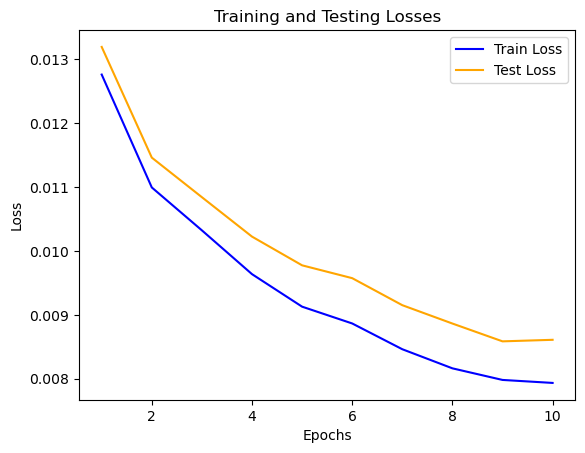

In [36]:
epochs = range(1, len(train_losses) + 1)

# Plot both training and testing losses
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, test_losses, label='Test Loss', color='orange')

# Adding titles and labels
plt.title('Training and Testing Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
    
# Show the plot
plt.show()

## FDP distribution

### Training Data

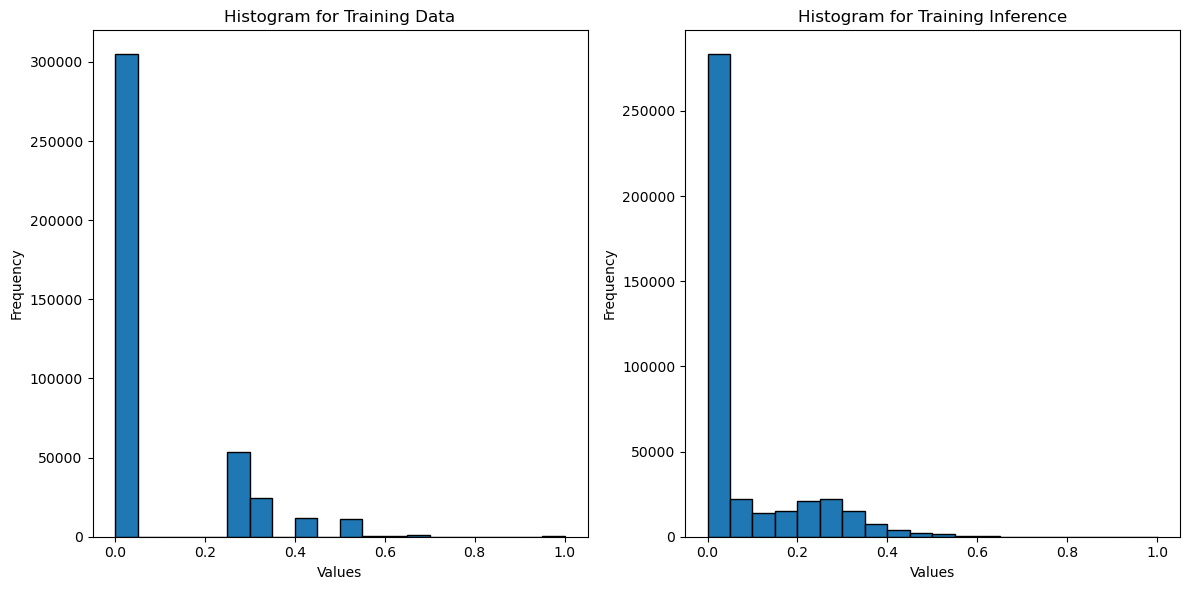

In [37]:
model.eval()

with torch.no_grad():
    train_loader_v = []
    train_infer_v = []
    for Phis, betas, vs, FDPs in train_loader:
        Phis, betas, vs, FDPs = Phis.to(device), betas.to(device), vs.to(device), FDPs.to(device)
        train_loader_v += FDPs.cpu().numpy().squeeze().tolist()
        train_infer_v += model(Phis, vs).detach().cpu().numpy().squeeze().tolist()

bin_edges = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(train_loader_v, bins=bin_edges, edgecolor='black')
ax1.set_title('Histogram for Training Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(train_infer_v, bins=bin_edges, edgecolor='black')
ax2.set_title('Histogram for Training Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

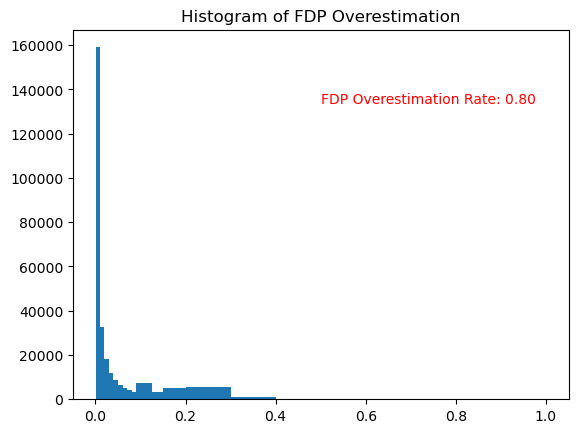

In [38]:
FDP_diff = np.array(train_infer_v) - np.array(train_loader_v)
FDP_overestimation = FDP_diff[FDP_diff > 0]
FDP_overestimation_rate = len(FDP_overestimation) / len(FDP_diff)

bin_edges = [0.0001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08 , 0.09 , 0.125, 0.15, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.001]
plt.hist(FDP_overestimation, bins=bin_edges)
plt.title("Histogram of FDP Overestimation")

# Add FDP overestimation rate as text
plt.text(0.5, plt.ylim()[1] * 0.8, f"FDP Overestimation Rate: {FDP_overestimation_rate:.2f}", fontsize=10, color='red')

# Show the plot
plt.show()

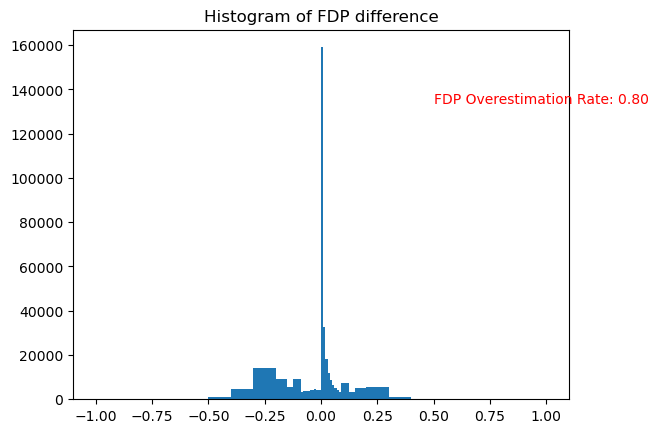

In [39]:
bin_edges = [-1.001, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.15, -0.125, -0.09 , -0.08 , -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.0001, 
             0, 0.0001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08 , 0.09 , 0.125, 0.15, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.001]
plt.hist(FDP_diff, bins=bin_edges)
plt.title("Histogram of FDP difference")

# Add FDP overestimation rate as text
plt.text(0.5, plt.ylim()[1] * 0.8, f"FDP Overestimation Rate: {FDP_overestimation_rate:.2f}", fontsize=10, color='red')

# Show the plot
plt.show()

### Test Data

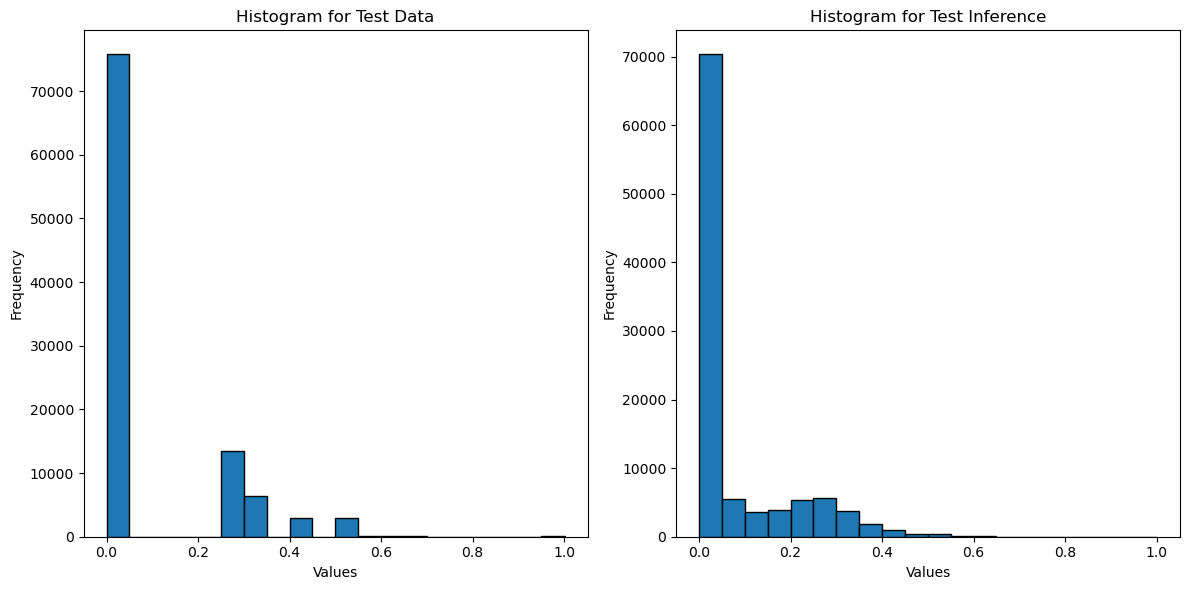

In [40]:
model.eval()

with torch.no_grad():
    test_loader_v = []
    test_infer_v = []
    for Phis, betas, vs, FDPs in test_loader:
        Phis, betas, vs, FDPs = Phis.to(device), betas.to(device), vs.to(device), FDPs.to(device)
        test_loader_v += FDPs.cpu().numpy().squeeze().tolist()
        test_infer_v += model(Phis, vs).detach().cpu().numpy().squeeze().tolist()

bin_edges = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(test_loader_v, bins=bin_edges, edgecolor='black')
ax1.set_title('Histogram for Test Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(test_infer_v, bins=bin_edges, edgecolor='black')
ax2.set_title('Histogram for Test Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

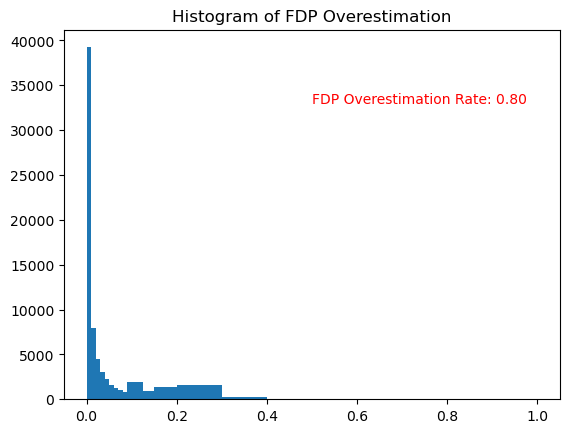

In [41]:
FDP_diff = np.array(test_infer_v) - np.array(test_loader_v)
FDP_overestimation = FDP_diff[FDP_diff > 0]
FDP_overestimation_rate = len(FDP_overestimation) / len(FDP_diff)

bin_edges = [0.0001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08 , 0.09 , 0.125, 0.15, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.001]
plt.hist(FDP_overestimation, bins=bin_edges)
plt.title("Histogram of FDP Overestimation")

# Add FDP overestimation rate as text
plt.text(0.5, plt.ylim()[1] * 0.8, f"FDP Overestimation Rate: {FDP_overestimation_rate:.2f}", fontsize=10, color='red')

# Show the plot
plt.show()

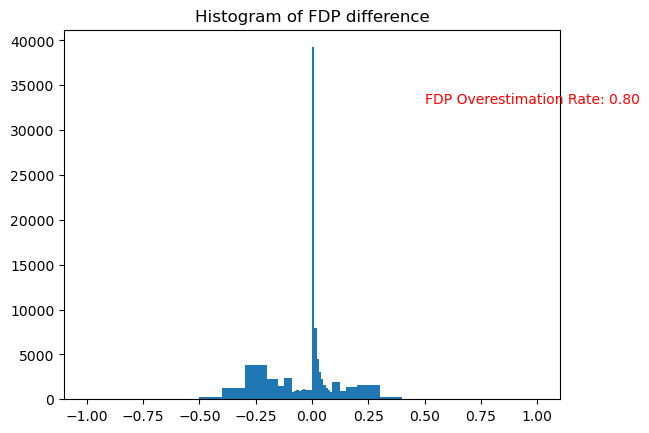

In [42]:
bin_edges = [-1.001, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.15, -0.125, -0.09 , -0.08 , -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.0001, 
             0, 0.0001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08 , 0.09 , 0.125, 0.15, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.001]
plt.hist(FDP_diff, bins=bin_edges)
plt.title("Histogram of FDP difference")

# Add FDP overestimation rate as text
plt.text(0.5, plt.ylim()[1] * 0.8, f"FDP Overestimation Rate: {FDP_overestimation_rate:.2f}", fontsize=10, color='red')

# Show the plot
plt.show()

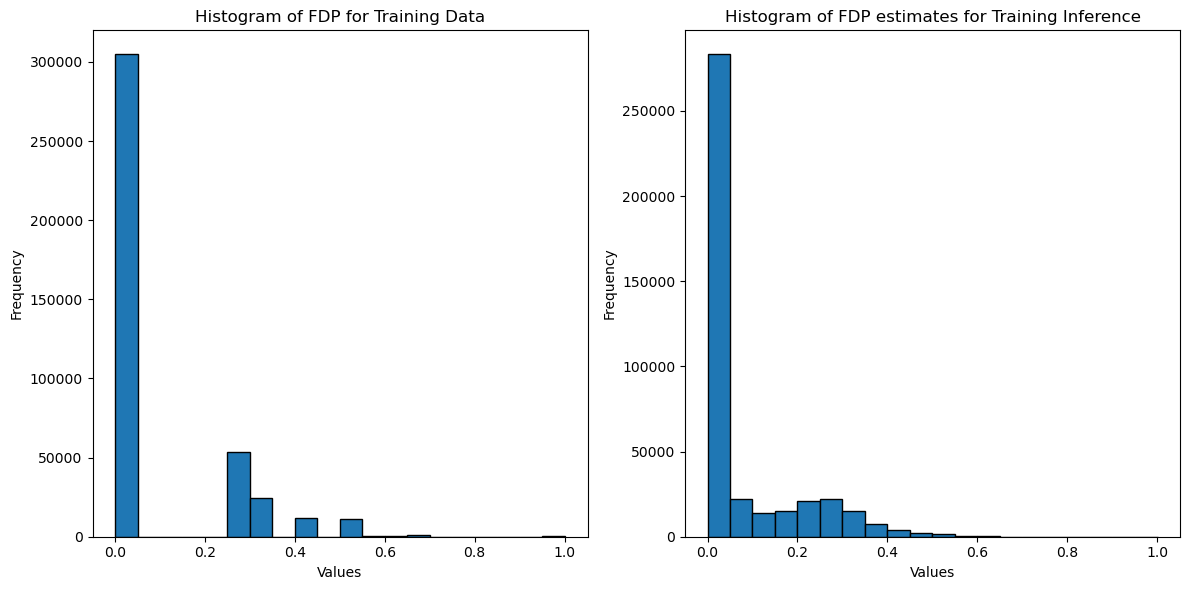

In [43]:
model.eval()

with torch.no_grad():
    train_loader_FDPs = []
    train_infer_FDP_ests = []
    for Phis, betas, vs, FDPs in train_loader:
        Phis, betas, vs, FDPs = Phis.to(device), betas.to(device), vs.to(device), FDPs.to(device)
        train_loader_FDPs += FDPs.cpu().numpy().squeeze().tolist()
        train_infer_FDP_ests += model(Phis, vs).detach().cpu().numpy().squeeze().tolist()

bin_edges = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(train_loader_FDPs, bins=bin_edges, edgecolor='black')
ax1.set_title('Histogram of FDP for Training Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(train_infer_FDP_ests, bins=bin_edges, edgecolor='black')
ax2.set_title('Histogram of FDP estimates for Training Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [44]:
class PhiThreshDatasetHash(Dataset):
    def __init__(self, data_dir):
        self.phi_dir = os.path.join(data_dir, 'Phi_mat')
        self.beta_dir = os.path.join(data_dir, 'beta')
        self.v_dir = os.path.join(data_dir, 'v')
        self.FDP_dir = os.path.join(data_dir, 'FDR')
        
        # Load all `Phi` files
        self.phi_files = [f for f in os.listdir(self.phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
        
        # Identify unique `Phis` based on their content
        self.unique_phis = {}
        for phi_file in self.phi_files:
            phi_path = os.path.join(self.phi_dir, phi_file)
            phi_content = np.loadtxt(phi_path)  # Load `Phi` content
            phi_hash = hash(phi_content.tobytes())  # Hash the content
            
            if phi_hash not in self.unique_phis:
                self.unique_phis[phi_hash] = phi_file  # Keep track of unique `Phis`
        
        # Use only the unique `Phi` files
        self.phi_files = list(self.unique_phis.values())
        self.beta_files = [f.replace('Phi_mat_', 'beta_') for f in self.phi_files]
        self.v_files = [f.replace('Phi_mat_', 'v_') for f in self.phi_files]
        self.FDP_files = [f.replace('Phi_mat_', 'FDR_') for f in self.phi_files]

    def __len__(self):
        return len(self.phi_files)

    def __getitem__(self, idx):
        phi_file = os.path.join(self.phi_dir, self.phi_files[idx])
        phi = np.loadtxt(phi_file)

        beta_file = os.path.join(self.beta_dir, self.beta_files[idx])
        beta = np.loadtxt(beta_file)
        
        v_file = os.path.join(self.v_dir, self.v_files[idx])
        v = np.loadtxt(v_file)
        
        FDP_file = os.path.join(self.FDP_dir, self.FDP_files[idx])
        FDP = np.loadtxt(FDP_file)

        return torch.tensor(phi, dtype=torch.float32), torch.tensor(beta, dtype=torch.float32), torch.tensor(v, dtype=torch.float32), torch.tensor(FDP, dtype=torch.float32)



def get_data_loaders_hash(data_dir, batch_size=32, test_size=0.2):
    dataset = PhiThreshDatasetHash(data_dir)
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)
    
    train_set = torch.utils.data.Subset(dataset, train_indices)
    test_set = torch.utils.data.Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_indices, test_indices

train_loader_hash, test_loader_hash, train_indices_hash, test_indices_hash = get_data_loaders_hash(data_dir, batch_size=hparams["batch_size"])

In [45]:
# Assuming alpha is the target threshold
alpha = 0.1  # Example target FDP threshold
v_min, v_max, v_step = 0.5, 1.0, 0.01  # Grid search range for v

model.eval()
train_loader_vs = []
train_infer_vs = []
train_infer_FDP_ests = []
test_loader_vs = []
test_infer_vs = []
test_infer_FDP_ests = []

with torch.no_grad():
    for Phis, betas, vs, FDPs in tqdm(train_loader_hash, desc="Processing Batches"):
        Phis, FDPs = Phis.to(device), FDPs.to(device)
        train_loader_vs += vs.cpu().numpy().squeeze().tolist()
        batch_optimal_vs = []
        batch_estimated_FDPs = []
        
        for i, Phi in enumerate(Phis):
            best_v = 0.5
            best_FDP = 0  # Start with the smallest possible value
            
            # Perform grid search for v in [0.5, 1] with step 0.01
            for v in np.arange(v_min, v_max + v_step, v_step):
                v_tensor = torch.tensor([v], device=device, dtype=torch.float32)
                FDP_est = model(Phi.unsqueeze(0), v_tensor).item()
                
                # Check if FDP_est is under alpha and closer to alpha from the left
                if FDP_est <= alpha and FDP_est > best_FDP:
                    best_FDP = FDP_est
                    best_v = v
            
            # Save the optimal v and corresponding FDP estimate for the current Phi
            batch_optimal_vs.append(best_v)
            batch_estimated_FDPs.append(best_FDP)
        
        train_infer_vs.extend(batch_optimal_vs)
        train_infer_FDP_ests.extend(batch_estimated_FDPs)
    
    for Phis, betas, vs, FDPs in tqdm(test_loader_hash, desc="Processing Batches"):
        Phis, FDPs = Phis.to(device), FDPs.to(device)
        test_loader_vs += vs.cpu().numpy().squeeze().tolist()
        batch_optimal_vs = []
        batch_estimated_FDPs = []
        
        for i, Phi in enumerate(Phis):
            best_v = 0.5
            best_FDP = 0  # Start with the smallest possible value
            
            # Perform grid search for v in [0.5, 1] with step 0.01
            for v in np.arange(v_min, v_max + v_step, v_step):
                v_tensor = torch.tensor([v], device=device, dtype=torch.float32)
                FDP_est = model(Phi.unsqueeze(0), v_tensor).item()
                
                # Check if FDP_est is under alpha and closer to alpha from the left
                if FDP_est <= alpha and FDP_est > best_FDP:
                    best_FDP = FDP_est
                    best_v = v
            
            # Save the optimal v and corresponding FDP estimate for the current Phi
            batch_optimal_vs.append(best_v)
            batch_estimated_FDPs.append(best_FDP)
        
        test_infer_vs.extend(batch_optimal_vs)
        test_infer_FDP_ests.extend(batch_estimated_FDPs)

Processing Batches: 100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


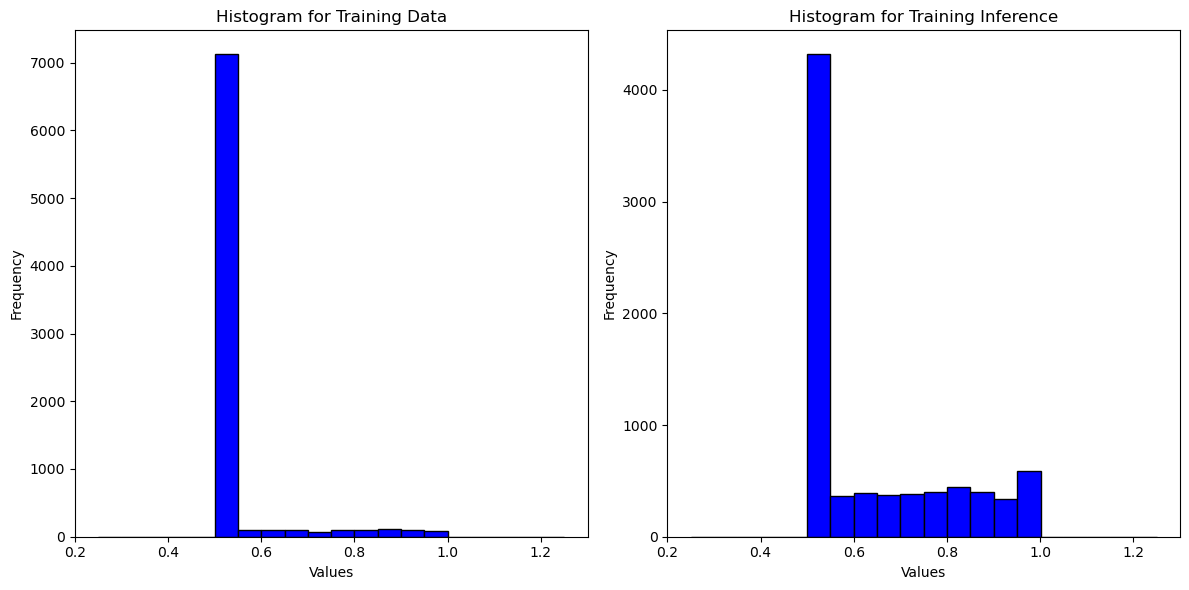

In [46]:
bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(train_loader_vs, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Training Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(train_infer_vs, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Training Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

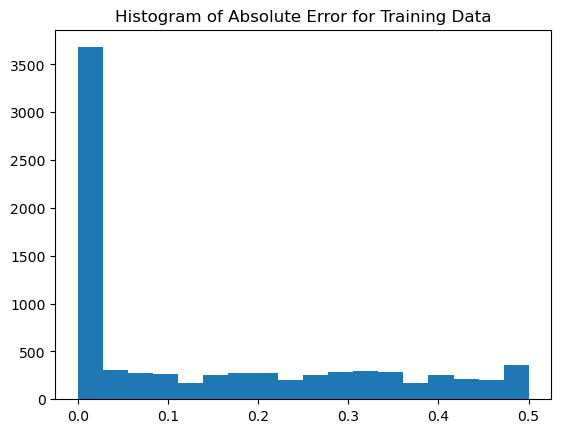

In [47]:
plt.hist(np.abs(np.array(train_loader_vs) - np.array(train_infer_vs)), bins='auto')
plt.title("Histogram of Absolute Error for Training Data")
plt.show()

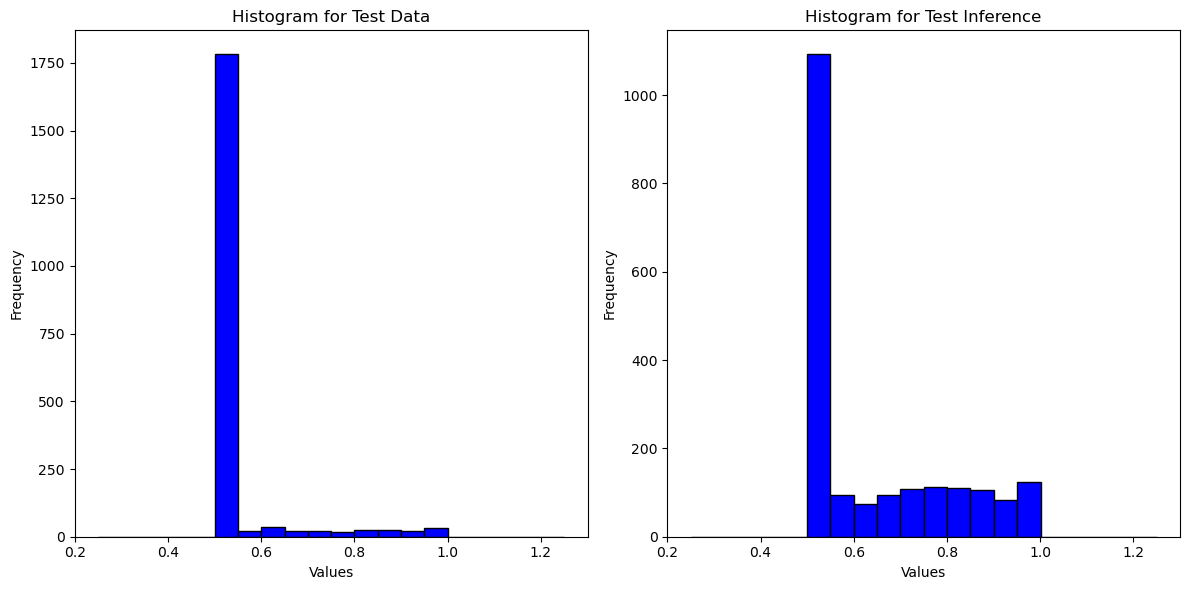

In [48]:
bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(test_loader_vs, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Test Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(test_infer_vs, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Test Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

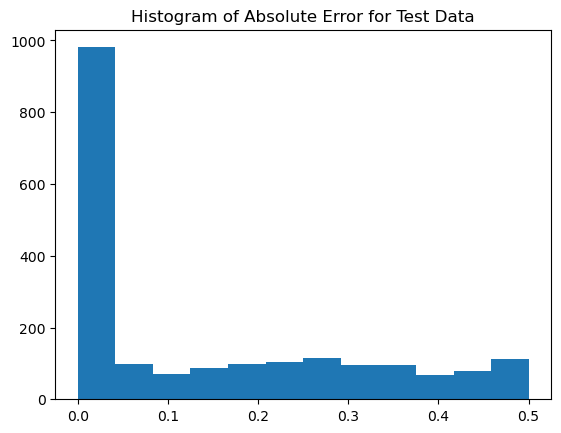

In [49]:
plt.hist(np.abs(np.array(test_loader_vs) - np.array(test_infer_vs)), bins='auto')
plt.title("Histogram of Absolute Error for Test Data")
plt.show()

In [50]:
FDPs = []  # or FDPs
TPPs = []  # or TPPs
FDPs_opt = []  # or FDPs
TPPs_opt = []  # or TPPs
i = 0

for Phis, betas, vs, _ in tqdm(train_loader_hash, desc="Processing Batches"):
    for batch_element in range(len(Phis)):
        phi, beta, v = Phis[batch_element].numpy(), betas[batch_element].numpy(), vs[batch_element].numpy()
        true_actives = np.nonzero(beta)[0]
        selected_opt = np.where(phi > v)[0]
        selected_actives_opt = np.intersect1d(selected_opt, true_actives, assume_unique=True)
        selected_null_opt = np.setdiff1d(selected_opt, selected_actives_opt, assume_unique=True)
        FDPs_opt.append(len(selected_null_opt) / max(len(selected_opt), 1))
        TPPs_opt.append(len(selected_actives_opt) / max(len(true_actives), 1))
        
        v_opt = train_infer_vs[i]
        selected = np.where(phi > v_opt)[0]
        selected_actives = np.intersect1d(selected, true_actives, assume_unique=True)
        selected_null = np.setdiff1d(selected, selected_actives, assume_unique=True)
        FDPs.append(len(selected_null)/max(len(selected), 1))
        TPPs.append(len(selected_actives)/max(len(true_actives), 1))
        i += 1

Processing Batches: 100%|██████████| 500/500 [00:03<00:00, 162.59it/s]


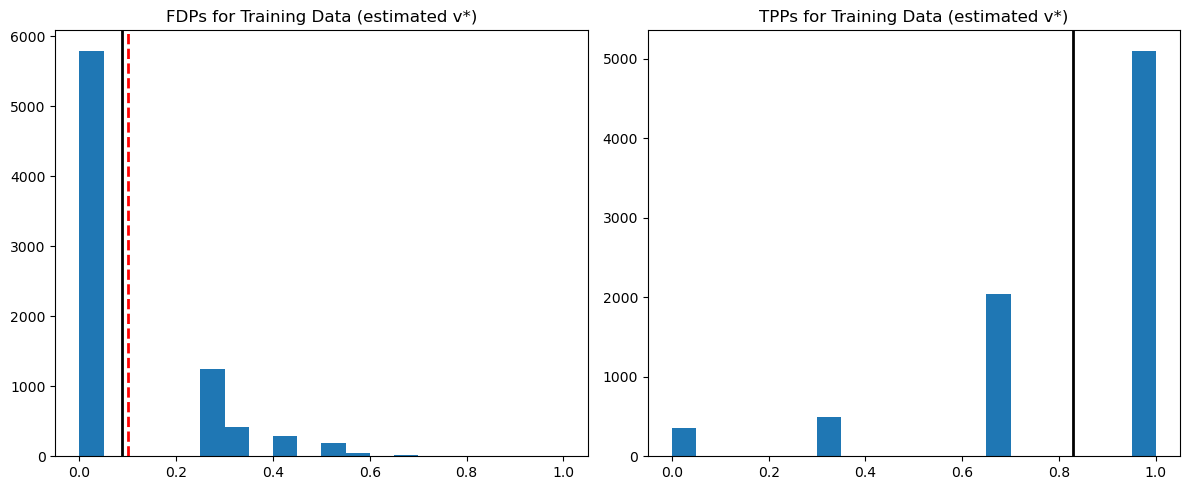

In [51]:
bins = np.arange(0, 1.05, 0.05)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(np.array(FDPs), bins=bins)
axs[0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
average_FDP = np.mean(FDPs)
axs[0].axvline(x=average_FDP, color='black', linestyle='-', linewidth=2)
axs[0].set_title("FDPs for Training Data (estimated v*)")

axs[1].hist(np.array(TPPs), bins=bins)
average_TPP = np.mean(TPPs)
axs[1].axvline(x=average_TPP, color='black', linestyle='-', linewidth=2)
axs[1].set_title("TPPs for Training Data (estimated v*)")

plt.tight_layout()

plt.show()